This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/sp_domainwall_pinning.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/sp_domainwall_pinning/ref/m.dat &> /dev/null

# Domainwall Pinning Standard Problem

## Run Simulation

In [2]:
from magnumnp import *
import numpy as np
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

Hextmax=1.8/constants.mu_0
Hextmin=1.4/constants.mu_0
tfinal = 20e-9

n  = (80, 1, 1)
dx = (1e-9, 1e-9, 1e-9)
origin = (-n[0]*dx[0]/2., -n[1]*dx[1]/2., -n[2]*dx[2]/2.,)
mesh = Mesh(n, dx, origin)
state = State(mesh)
state.material = {"alpha": state.Constant(1.)}
x, y, z = mesh.SpatialCoordinate()

soft = (x < 0)
hard = (x >= 0)

Ms = state.Constant(0.0)
Ms[soft] = 0.25/constants.mu_0
Ms[hard] = 1./constants.mu_0

Ku = state.Constant(0.0)
Ku[soft] = 1e5
Ku[hard] = 1e6

A = state.Constant(0.0)
A[soft] = 0.25e-11
A[hard] = 1.e-11

state.material['Ms'] = Ms
state.material['A'] = A
state.material['Ku'] = Ku
state.material['Ku_axis'] = state.Constant([0,1,0])

state.m = state.Constant([np.sin(0.3), np.cos(0.3), 0.0])
state.m[hard] = torch.tensor([0.0, -1.0, 0.0])
normalize(state.m)

exchange = ExchangeField()
aniso    = UniaxialAnisotropyField()
external = ExternalField(state.Constant([0, 0, 0]))

minimizer = MinimizerBB([exchange, aniso, external])
logger = ScalarLogger(this_dir / "data" / "m.dat", ['t', external.h, 'm'])
for h in tqdm(torch.linspace(Hextmin, Hextmax, steps=100)):
    external.h = state.Constant([0, h, 0])
    minimizer.minimize(state)
    logger << state

Timer.print_report()

2024-11-08 10:26:10  magnum.np:INFO magnum.np 2.0.1


2024-11-08 10:26:10  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2024-11-08 10:26:10  magnum.np:INFO [Mesh] 80x1x1 (dx= 1e-09 x 1e-09 x 1e-09)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:10<17:07, 10.38s/it]

  4%|▍         | 4/100 [00:10<03:12,  2.00s/it]

  7%|▋         | 7/100 [00:10<01:28,  1.05it/s]

 10%|█         | 10/100 [00:10<00:50,  1.77it/s]

 12%|█▏        | 12/100 [00:10<00:36,  2.41it/s]

 15%|█▌        | 15/100 [00:11<00:23,  3.66it/s]

 18%|█▊        | 18/100 [00:11<00:15,  5.17it/s]

 21%|██        | 21/100 [00:11<00:11,  6.88it/s]

 24%|██▍       | 24/100 [00:11<00:08,  8.58it/s]

 26%|██▌       | 26/100 [00:11<00:07,  9.70it/s]

 28%|██▊       | 28/100 [00:11<00:06, 10.73it/s]

 30%|███       | 30/100 [00:11<00:06, 11.11it/s]

 32%|███▏      | 32/100 [00:12<00:05, 11.58it/s]

 34%|███▍      | 34/100 [00:12<00:05, 11.99it/s]

 36%|███▌      | 36/100 [00:12<00:05, 12.09it/s]

 38%|███▊      | 38/100 [00:12<00:05, 12.37it/s]

 40%|████      | 40/100 [00:12<00:05, 11.58it/s]

 42%|████▏     | 42/100 [00:12<00:04, 11.83it/s]

 44%|████▍     | 44/100 [00:13<00:06,  9.30it/s]

 46%|████▌     | 46/100 [00:13<00:05,  9.00it/s]

 73%|███████▎  | 73/100 [00:13<00:00, 50.94it/s]

100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                     100      133.774           13.3774
    ExchangeField.h                     4154        1.87175          7.77526
    UniaxialAnisotropyField.h           4154        0.740204         3.07481
    ExternalField.h                     4154        0.0116102        0.048229
ExternalField.h                          100        0.0112997        0.00112997
-----------------------------  -------------  ---------------  ----------------
Total                                                               13.7055
Missing                                                              0.326975



## Plot Results

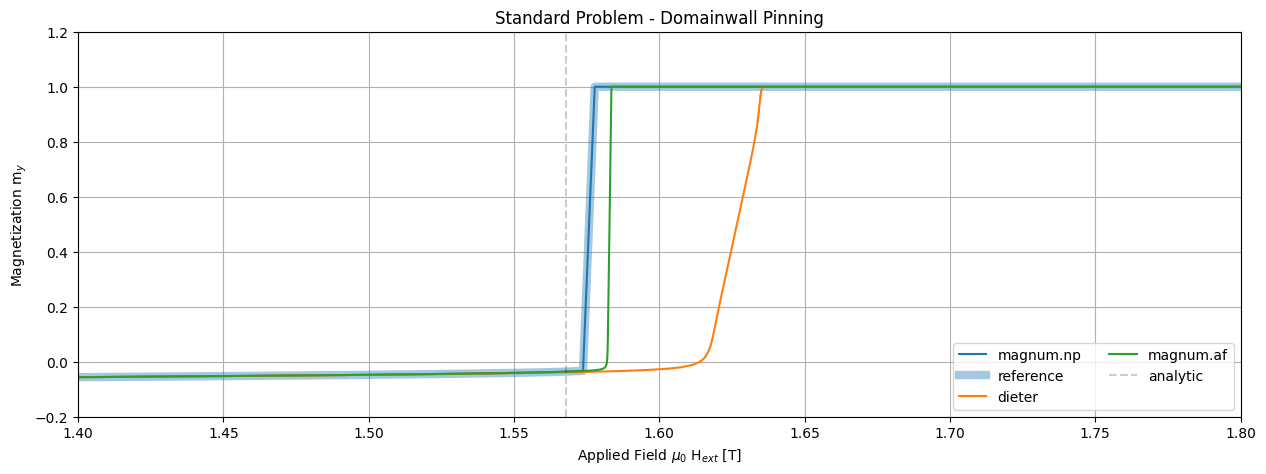

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("data/m.dat")
ref = np.loadtxt("ref/m_ref.dat")
data_dieter = np.loadtxt("ref/m_dieter.dat")
data_magnumaf = np.loadtxt("ref/m_magnumaf.dat")


fig, ax = plt.subplots(figsize=(15,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(data[:,2]*4*np.pi*1e-7, data[:,5], '-', color = cycle[0], label = "magnum.np")
ax.plot(ref[:,2]*4*np.pi*1e-7, ref[:,5], '-', color = cycle[0], linewidth = 6, alpha = 0.4, label = "reference")
ax.plot(data_dieter[:,1], data_dieter[:,3], '-', color = cycle[1], label = "dieter")
ax.plot(data_magnumaf[:,4]*4*np.pi*1e-7, data_magnumaf[:,2], '-', color = cycle[2], label = "magnum.af")
ax.axvline(x = 1.568, linestyle = '--', color = 'black', alpha = 0.2, label = 'analytic')

ax.set_xlim([1.4,1.8])
ax.set_ylim([-0.2,1.2])
ax.set_title("Standard Problem - Domainwall Pinning")
ax.set_xlabel("Applied Field $\mu$$_0$ H$_{ext}$ [T]")
ax.set_ylabel("Magnetization m$_y$")
ax.legend(ncol=2, loc='lower right')
ax.grid()
fig.savefig("data/results.png")